In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from treeffuser import Treeffuser

from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import ConfusionMatrixDisplay, mean_squared_error, roc_auc_score

from data import load_amp, load_uke, GENERATIVE_COLUMNS

X_amp, scores = load_amp(
    "../data/updrs_amp_all.csv", sample_one_measurement_per_subject=True
)
X_amp[GENERATIVE_COLUMNS]

,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,PDQ,MoCA
0,17.307692,21.153846,11.363636,37.500000,NaN,96.666667
1,15.384615,21.153846,9.090909,16.666667,NaN,100.000000
2,19.230769,21.153846,25.000000,25.000000,NaN,93.333333
3,17.307692,26.923077,22.727273,0.000000,NaN,83.333333
4,NaN,NaN,17.424242,33.333333,NaN,NaN
...,...,...,...,...,...,...
3147,15.384615,11.538462,11.363636,4.166667,0.781250,93.333333
3148,19.230769,28.846154,21.212121,0.000000,17.031250,96.666667
3149,19.230769,9.615385,7.575758,0.000000,9.843750,90.000000
3150,5.769231,9.615385,16.666667,0.000000,1.041667,100.000000


In [2]:
x_uke, covariates_uke, y_uke = load_uke("../data/pdq_uke_new.csv")

valid_measurements = (~pd.isna(x_uke["PDQ"])) & (~pd.isna(y_uke["PDQ"]))
x_uke = x_uke[valid_measurements]
covariates_uke = covariates_uke[valid_measurements]
y_uke = y_uke[valid_measurements]

x_uke

,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,PDQ,MoCA
0,7.692308,21.153846,18.181818,41.666667,12.656250,NaN
1,13.461538,19.230769,32.575758,0.000000,5.468750,96.666667
2,17.307692,25.000000,19.696970,16.666667,28.906250,80.000000
4,5.769231,38.461538,22.727273,58.333333,16.562500,90.000000
5,13.461538,28.846154,27.272727,41.666667,30.416667,93.333333
6,26.923077,55.769231,28.787879,45.833333,50.052083,100.000000
7,13.461538,3.846154,22.727273,45.833333,14.114583,90.000000
8,15.384615,25.000000,14.393939,45.833333,28.854167,86.666667
9,17.307692,25.000000,34.090909,NaN,11.041667,90.000000
10,26.923077,28.846154,18.939394,41.666667,35.781250,100.000000


## Train the model

In [3]:
model = Treeffuser(seed=42)
model.fit(scores.to_numpy(), X_amp[GENERATIVE_COLUMNS].to_numpy())

/usr/local/lib/python3.10/dist-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/usr/local/lib/python3.10/dist-packages/treeffuser/_base_tabular_diffusion.py:113: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  y = _check_array(y)


Treeffuser(extra_lightgbm_params={}, seed=42)

In [4]:
def generate_samples(model, x, x_covariates, n_samples: int = 50) -> pd.DataFrame:
    generated_samples = []
    prediction = np.clip(model.sample(x_covariates, n_samples=n_samples, seed=42), 0, 100)

    for i, (subject_id, ground_truth) in enumerate(x.iterrows()):
        for i_key, (key, value) in enumerate(ground_truth.items()):
            if pd.isna(value):
                continue

            generated_samples.append(
                pd.DataFrame.from_dict(
                    {
                        "Prediction": prediction[:, i, i_key],
                        "Ground truth": value,
                        "Score": key,
                        "Subject": subject_id,
                        "Sample ID": np.arange(n_samples),
                    }
                )
            )

    return pd.concat(generated_samples, ignore_index=True)


uke_samples = generate_samples(
    model, x_uke[GENERATIVE_COLUMNS], covariates_uke.to_numpy(), n_samples=500
)

/usr/local/lib/python3.10/dist-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)


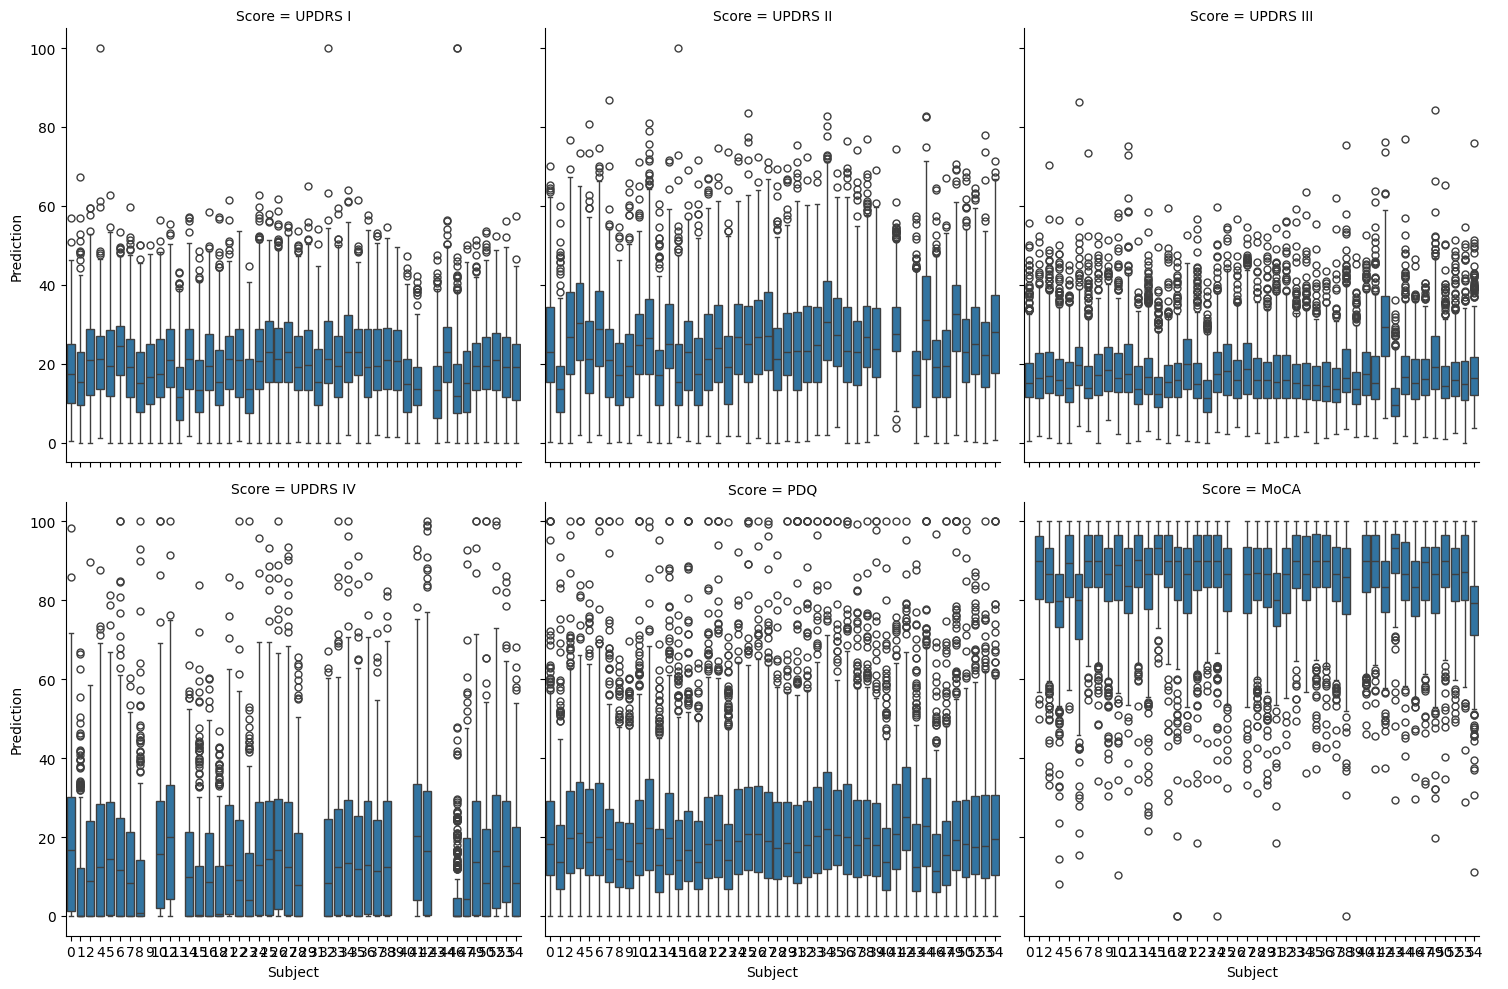

In [5]:
sns.catplot(
    data=uke_samples, x="Subject", y="Prediction", col="Score", col_wrap=3, kind="box"
)

18.511704426401504
17.317999218671023


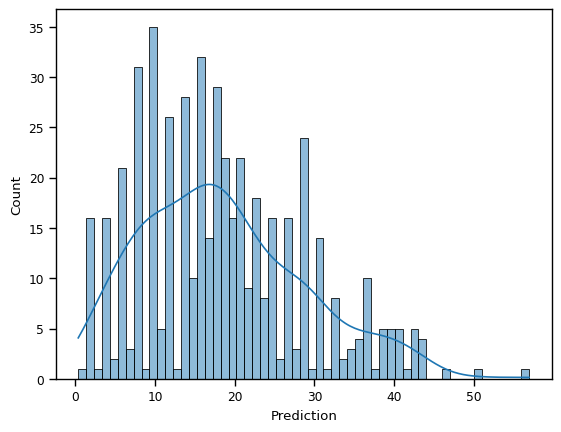

In [15]:
selection = uke_samples[
    (uke_samples["Score"] == "UPDRS I") & (uke_samples["Subject"] == 0)
]

sns.histplot(selection, x="Prediction", binwidth=1, kde=True)

print(selection["Prediction"].mean())
print(selection["Prediction"].median())

In [7]:
z_scores = []
for subject, data in uke_samples.groupby("Subject"):
    for score, score_data in data.groupby("Score"):
        # mean = score_data["Prediction"].median()
        # std = score_data["Prediction"].std()
        mean = score_data["Prediction"].median()
        std = (score_data["Prediction"] - mean).abs().median() + 1e-6

        ground_truth = score_data["Ground truth"].iloc[0]
        ground_truth_score = (ground_truth - mean) / std
        z_scores.append((subject, score, ground_truth_score))

z_scores = (
    pd.DataFrame.from_records(z_scores, columns=["Subject", "Score", "Z-Score"])
    .pivot(index="Subject", columns="Score", values="Z-Score")
    .reset_index()
    .set_index("Subject")
)
z_scores["Label"] = (x_uke["PDQ"] - y_uke["PDQ"]) > 4.72

z_scores

Score,MoCA,PDQ,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,Label
Subject,,,,,,,
0,NaN,-0.630976,-1.270298,-0.189066,0.761642,1.789614,False
1,1.009812,-1.100211,-0.262116,0.984353,2.790691,-0.999992,False
2,-0.978784,0.930993,-0.490935,-0.193492,0.618567,0.902967,False
4,1.501882,-0.424065,-2.442050,0.861651,1.465226,3.737353,False
5,0.544292,1.180794,-0.761489,0.804396,2.971511,1.905085,True
6,2.939108,2.733936,0.378322,2.817290,1.838655,2.978807,True
7,-0.009246,-0.328253,-0.741492,-1.822098,2.343977,4.436703,True
8,-0.500344,1.800925,0.023188,0.985231,-0.553518,59.843824,True
9,0.490759,-0.376797,0.085455,0.729964,2.764868,NaN,False


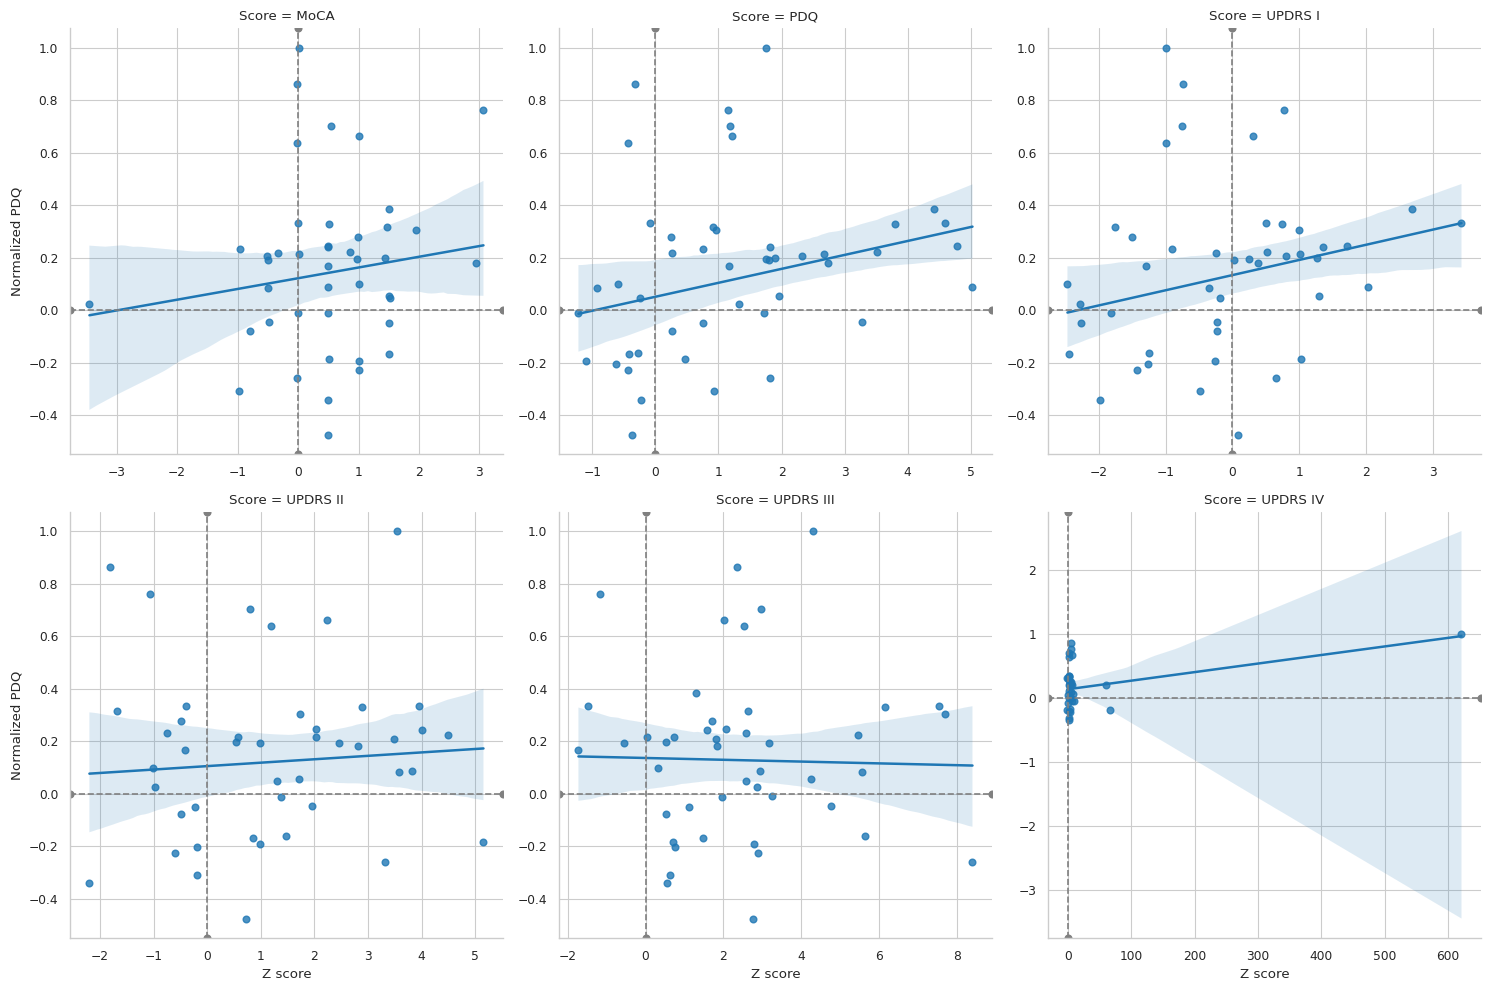

In [8]:
regscores = z_scores.copy()
regscores["Normalized PDQ"] = (x_uke["PDQ"] - y_uke["PDQ"]) / (
    x_uke["PDQ"] + y_uke["PDQ"]
)
regscores = regscores.reset_index().melt(
    id_vars=["Subject", "Label", "Normalized PDQ"], value_name="Z score"
)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    g = sns.lmplot(
        data=regscores,
        x="Z score",
        y="Normalized PDQ",
        col="Score",
        col_wrap=3,
        facet_kws=dict(sharex=False, sharey=False),
        robust=True,
    )
    g.refline(y=0, x=0)

## Predict the effect

In [9]:
CONDITIONS = {
    "demographical data and QoL": pd.concat(
        (covariates_uke[["Age", "Sex", "Time since diagnosis"]], x_uke["PDQ"]), axis=1
    ),
    "demographical data and scores (QoL included)": pd.concat(
        (covariates_uke[["Age", "Sex", "Time since diagnosis"]], x_uke), axis=1
    ),
    "relative scores only": z_scores.drop(columns=["Label"]).round(2),
}

cv = LeaveOneOut()
y = (x_uke["PDQ"] - y_uke["PDQ"]) / (x_uke["PDQ"] + y_uke["PDQ"])

predictions = []
for condition, x in CONDITIONS.items():
    y_pred = cross_val_predict(
        HistGradientBoostingRegressor(min_samples_leaf=5, max_depth=3),
        x,
        y,
        cv=cv,
    )

    predictions.append(
        pd.DataFrame(
            {"Normalized PDQ": y, "Model prediction": y_pred, "Condition": condition}
        )
    )

predictions = pd.concat(predictions, ignore_index=True)

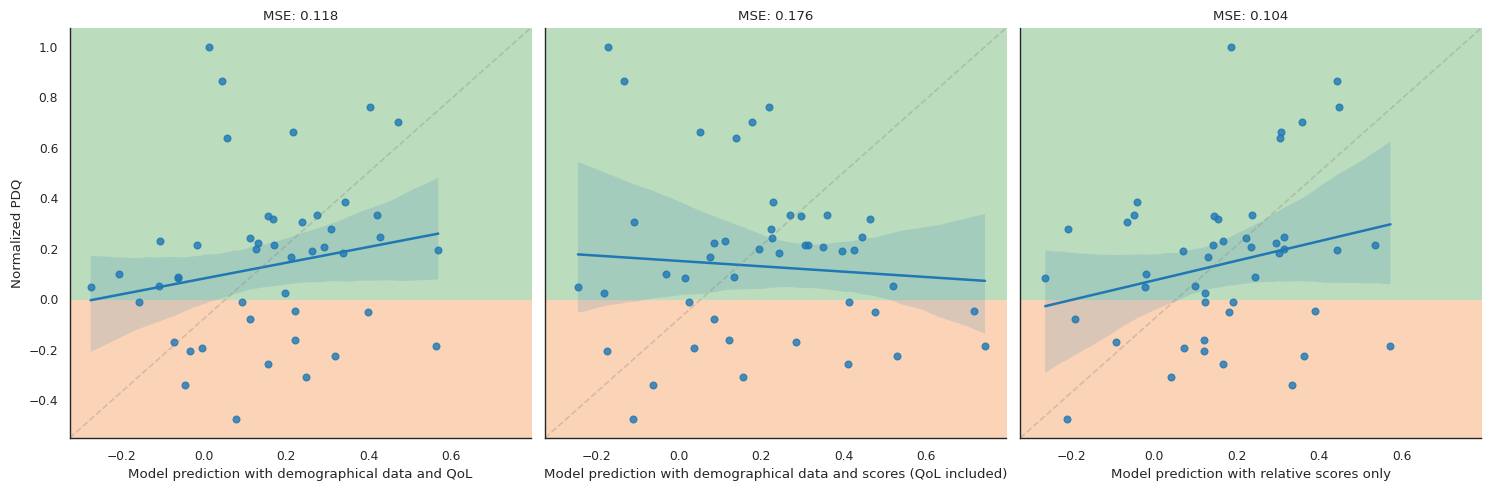

In [10]:
def annotate(data, **kws):
    ax = plt.gca()
    ax.plot(
        [0, 1], [0, 1], transform=ax.transAxes, color="gray", linestyle="--", alpha=0.3
    )

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.fill_betweenx(
        y=[max(y_min, 0), y_min],
        x1=x_min,
        x2=x_max,
        color=(251 / 255, 212 / 255, 183 / 255),
        zorder=-100,
    )
    ax.fill_betweenx(
        y=[0.0, y_max],
        x1=x_min,
        x2=x_max,
        color=(188 / 255, 220 / 255, 190 / 255),
        zorder=-100,
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xlabel(f"Model prediction with {data['Condition'].iloc[0]}")
    ax.set_title(
        f"MSE: {mean_squared_error(data['Normalized PDQ'], data['Model prediction']):.3f}"
    )


with sns.axes_style("white"):
    sns.set_context("paper")

    grid = sns.lmplot(
        data=predictions,
        y="Normalized PDQ",
        x="Model prediction",
        col="Condition",
        robust=True,
    )
    grid.map_dataframe(annotate)


## Classify the effect

In [11]:
cv = LeaveOneOut()
y = (x_uke["PDQ"] - y_uke["PDQ"]) >= 4.3

predictions = []
for condition, x in CONDITIONS.items():
    y_pred = cross_val_predict(
        HistGradientBoostingClassifier(min_samples_leaf=5, max_depth=3),
        x,
        y,
        cv=cv,
    )

    predictions.append(
        pd.DataFrame({"Ground truth": y, "Prediction": y_pred, "Condition": condition})
    )

predictions = pd.concat(predictions, ignore_index=True)

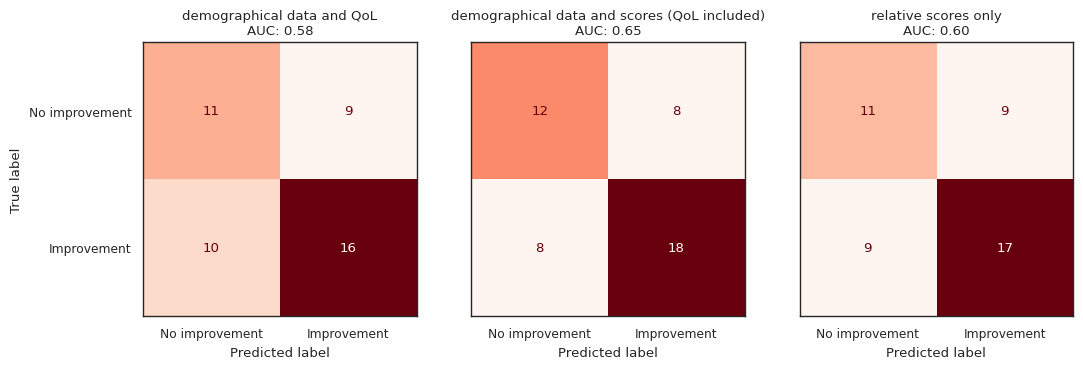

In [12]:
with sns.axes_style("white"):
    sns.set_context("paper")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, ((condition, data), ax) in enumerate(
        zip(predictions.groupby("Condition"), axes)
    ):
        ConfusionMatrixDisplay.from_predictions(
            y_true=data["Ground truth"],
            y_pred=data["Prediction"],
            ax=ax,
            colorbar=False,
            cmap="Reds",
            display_labels=["No improvement", "Improvement"],
        )
        ax.set_title(
            f"{condition}\nAUC: {roc_auc_score(data['Ground truth'], data['Prediction']):.2f}"
        )
        if i > 0:
            ax.set_ylabel("")
            ax.set_yticklabels(["", ""])